In [2]:
# Pour installer cupy 

!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   6960      0 --:--:-- --:--:-- --:--:--  6929
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
import cupy as cp
import numpy as np
import time
import matplotlib.pyplot as plt
from __future__ import print_function

In [0]:
#GAP_SCORE = -3
#MATCH_SCORE_TWO_SEQ = 100
#PENALTY_3_ALIGNMENTS = 120


GAP_SCORE = -8
MATCH_SCORE_TWO_SEQ = 70
PENALTY_3_ALIGNMENTS = 0

# With PENALTY_3_ALIGNMENTS = 120

# Not bad with lambda = 120 and GAP_SCORE = -8
# Maybe better with lambda = 100 and GAP_SCORE = -8
# Good with lambda = 90 and GAP_SCORE = -8
# Maybe better with lambda = 82 and GAP_SCORE = -8
# Maybe better with lambda = 84 and GAP_SCORE = -6
# Maybe better with lambda = 84 and GAP_SCORE = -3


In [0]:
import numpy as np
from sympy import binomial
import os
from __future__ import print_function

In [0]:
def arrayPositionInMatrix(len_sequence, number_cells_computed):
    """
    
    Creates a 1D arrays which indicate for each time step the position 
    of the cells to compute in a Needleman and Wunch flattened matrix. 
    Works only for the alignment of 3 sequences with the same size.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
      
    number_cells_computed: 1D array
        Array which indicate the cumulative total number of cells computed 
        at each time step.
    
    Returns
    -------
    position_in_nw_flatten_matrix: 1D array
        Array which indicate the position of the cells to compute in a Needleman
        and Wunch flattened matrix.
    """
    
    number_steps = 3 * len_sequence - 2  # We can know the number of time steps to entirely compute the NW matrix with the theorie
    shape_matrix = ((len_sequence + 1, len_sequence + 1, len_sequence + 1)) # The "+ 1" to not be bothered with the boundaries

    position_x = [0] # position x of the elements which are computed in a 3D matrix
    position_y = [0] # position y of the elements which are computed in a 3D matrix
    position_z = [0] # position z of the elements which are computed in a 3D matrix

    position_in_nw_flatten_matrix = np.empty(shape=((len_sequence)**3, ), dtype=np.int32)
    # Needleman and Wunch matrix flattened 

    for time in range(1, number_steps + 1):
        print("\r{} / {}".format(time, number_steps), end='')
        position_cells_to_compute = np.vstack((position_x, position_y, position_z))


         
        interval1 = number_cells_computed[time-1]
        interval2 = number_cells_computed[time]

        position_in_nw_flatten_matrix[interval1:interval2] = np.ravel_multi_index(position_cells_to_compute + 1, shape_matrix) # The "+ 1" to not be bothered with the boundaries


        ## We update the position of the cells to compute for the next time step
        if (time < len_sequence):
            compteur = 0
            for i in range(time+1):
                position_x.insert(compteur, time-i)
                compteur += i+1

            position_y += list(np.arange(time + 1))
            position_z += list(np.arange(time, -1, -1))
        elif (time < 2 * len_sequence):
            compteur = 0
            for i in range(len_sequence):
                if (i+1 < 2*len_sequence - time):
                    position_x.insert(compteur, len_sequence - i - 1)
                    if (compteur == 0):
                        compteur += time - len_sequence + 2
                    else:
                        compteur += time - len_sequence + 2+i
                else:
                    position_x.pop(compteur)
                    compteur += len_sequence + 2*len_sequence - time - 2 - i

            position_y = position_y[time-len_sequence+1:] + list(np.arange(time-len_sequence + 1, len_sequence))
            position_z = position_z[time-len_sequence+1:] + list(np.arange(len_sequence - 1, time-len_sequence, -1))

        else:
            compteur = 0
            for i in range(3*len_sequence - time - 1):
                position_x.pop(compteur)
                compteur += 3*len_sequence - time - 2 - i

            position_y = position_y[3*len_sequence - time -1 :]
            position_z = position_z[3*len_sequence - time - 1:]

    return position_in_nw_flatten_matrix

In [0]:
def CalculProcessingUnitRequired(dimension, time_step, len_sequence):
  
    """
    
    Calculate for a time step the number of cells which can be computed in
    parallele in a Needleman and Wunch matrix.
    
    
    Parameters
    ----------
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
      
    time_step: int
        Time step 
        
    len_sequence: int
        The size of the sequences which are aligned.
    
    Returns
    -------
    number_cells: int
        Number of cells which can be computed in parallele.
  
  
    """
    
    number_cells = 0
    coefficient_to_add = time_step // len_sequence
    for q in range(coefficient_to_add + 1):
        coefficient = int((-1)**(q) * binomial(dimension + time_step - q*len_sequence - 2, time_step - q*len_sequence - 1) * binomial(dimension, q))
        number_cells += coefficient
    return number_cells


def getNumberProcessingUnitRequired(len_sequence, dimension): # Calcule le nombre de processing unit entre time = 0 et time = (NM - N-1) 
  
    """
    
    Create an array where each elements of index i indicate the number of cells 
    which can be computed in parallele in a Needleman and Wunch matrix at the 
    time step i.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
    
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
        
    Returns
    -------
    nb_cells_by_time_step: 1D array
        Array where each element of index i indicate the number of cells that 
        you can compute in a Needleman and Wunch matrix at time step = i
    
    
    """
    
    number_time_step = (dimension * len_sequence) - (dimension-1) # See the theorie to understand the total number of time step 
    nb_cells_by_time_step = np.empty((number_time_step+1, ), np.int32)
    nb_cells_by_time_step[0] = 0 # at time step 0, we compute 0 cells
    for i in range(1, number_time_step + 1): 
        nb_cells_by_time_step[i] = CalculProcessingUnitRequired(dimension, i, len_sequence)
    return nb_cells_by_time_step

In [8]:
len_sequence = 450 # Enter the sequence you want here
len_sequence += 1 # The sequences which are aligned have a size len_sequence + 1 because we add a gap element at the beginning of the sequences
nb_cells_by_time_step = getNumberProcessingUnitRequired(len_sequence, 3)
cumul_cells = nb_cells_by_time_step.cumsum()
position_in_nw_flatten_matrix = arrayPositionInMatrix(len_sequence, cumul_cells)

1351 / 1351

In [9]:
print("\nSAVING THE POSITION OBTAINED")

name_directory = "lenSeq_" + str(len_sequence)
!mkdir $name_directory

np.save(name_directory + "/position_cells_to_compute", position_in_nw_flatten_matrix) # M^N SPACE
np.save(name_directory + "/number_cells_computed", cumul_cells) # M*N SPACE

print("END OF SAVING")


SAVING THE POSITION OBTAINED
END OF SAVING


In [0]:
def computeScoringMatrix(seq1, seq2, seq3):
    tempsPasseAtEachStep = []
    lenSequence = len(seq1)
    scoreMatrix = cp.zeros((lenSequence + 1, lenSequence + 1, lenSequence + 1), cp.int32) # THE +1 TO NOT HAVE PROBLEMS WITH THE BOUNDARIES


    scoreMatrix[0, :, :] = scoreMatrix[:, :, 0] = scoreMatrix[:, 0, :] = - 256*lenSequence
    scoreMatrix[1, 1, 1] = 0 # to help us


    scoreMatrix_flatten = scoreMatrix.ravel()
    shapeMatrix = scoreMatrix.shape
    findPathMatrix = cp.zeros((lenSequence, lenSequence, lenSequence))
    total_number_steps = 3 * lenSequence - 2




    for step in range(2, total_number_steps + 1):
        begin = time.time()
        print("\r{} / {}".format(step, total_number_steps), end='')

        interval1 = indexPositionArray[step-1]
        interval2 = indexPositionArray[step]
        
        pos_cells_to_compute = position_in_nw_flatten_matrix[interval1:interval2]
        #We get the position of all the neighbooring cells
        
        scoreMatrix_depth_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2]
        scoreMatrix_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)]
        scoreMatrix_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - 1]

        scoreMatrix_depth_line_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1)]
        scoreMatrix_depth_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - 1]
        scoreMatrix_line_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1) - 1]

        scoreMatrix_depth_line_column_minus1 = scoreMatrix_flatten[pos_cells_to_compute - (lenSequence+1)**2 - (lenSequence+1) - 1]
        
        
        
        
        
        ## Compute the state for the changements in 1 dimension:
        maxOneDimMinusOne = cp.maximum(scoreMatrix_depth_minus1, cp.maximum(scoreMatrix_line_minus1, scoreMatrix_column_minus1)) + 2*GAP_SCORE
        
        a = MATCH_SCORE_TWO_SEQ - cp.abs(seq1[elementChoosen_history[interval1:interval2]] - seq2[elementChoosen_history[(lenSequence)**3+interval1:(lenSequence)**3+interval2]])
        b = MATCH_SCORE_TWO_SEQ- cp.abs(seq1[elementChoosen_history[interval1:interval2]] - seq3[elementChoosen_history[2*(lenSequence)**3+interval1:2*(lenSequence)**3+interval2]])
        c = MATCH_SCORE_TWO_SEQ - cp.abs(seq2[elementChoosen_history[(lenSequence)**3+interval1:(lenSequence)**3+interval2]] - seq3[elementChoosen_history[2*(lenSequence)**3+interval1:2*(lenSequence)**3+interval2]])
        

        ## Compute the state for the changements in 2 dimension:
        scoreMatrix_depth_line_minus1 +=  a
        scoreMatrix_depth_column_minus1 += b
        scoreMatrix_line_column_minus1 += c


        maxTwoDimMinusOne = cp.maximum(scoreMatrix_depth_line_minus1, cp.maximum(scoreMatrix_depth_column_minus1, scoreMatrix_line_column_minus1)) + GAP_SCORE

        ## Compute the state for the changements in 3 dimension:

        scoreMatrix_depth_line_column_minus1 += a+b+c - PENALTY_3_ALIGNMENTS


        # We put the maximum value in the matrix:
        scoreMatrix_flatten[pos_cells_to_compute] = cp.maximum(maxOneDimMinusOne, cp.maximum(maxTwoDimMinusOne, scoreMatrix_depth_line_column_minus1))

        end = time.time()
        tempsPasseAtEachStep.append(end - begin)
        #print("Temps passe : {}".format(end - begin))
    return scoreMatrix, tempsPasseAtEachStep

In [0]:
"""
Converts a tuple of index arrays into an array of flat indices (just in dimmension 3)
Inputs : index: tuple of index arrays
shape : shape of the matrix
(See numpy : tuple_multi_index for more precision (this function is not implemented in cupy))
"""

def ravel_multi_index(index, shape): # Ne marche qu'en dimension 3
  return index[0][0] * shape[0]**2 + index[1][0] * shape[1] + index[2][0]

In [0]:
def determinatePath(scoreMatrix, shapeMatrix):
    a = np.zeros((7, ))
    vector_path = np.zeros((3, 1), np.int32)
    vector_path[0] = vector_path[1] = vector_path[2] = shapeMatrix[0] - 1
    path = []

    scoreMatrix_flatten = scoreMatrix.flatten()
    new_path = np.array([ [[1], [0], [0]], [[0], [1], [0]], [[0], [0], [1]], [[1], [1], [0]], [[1], [0], [1]], [[0], [1], [1]], [[1], [1], [1]]  ])
    
    #Mask column :
    vector_mask_depth = np.zeros((3, 1), np.int32)
    vector_mask_depth[0][0] = 1

    vector_mask_line = np.zeros((3, 1) ,np.int32)
    vector_mask_line[1][0] = 1

    vector_mask_column = np.zeros((3, 1), np.int32)
    vector_mask_column[2][0] = 1

    vector_mask_depth_line = np.zeros((3, 1), np.int32)
    vector_mask_depth_line[0][0] = 1
    vector_mask_depth_line[1][0] = 1

    vector_mask_depth_column = np.zeros((3, 1), np.int32)
    vector_mask_depth_column[0][0] = 1
    vector_mask_depth_column[2][0] = 1

    vector_mask_line_column = np.zeros((3, 1), np.int32)
    vector_mask_line_column[1][0] = 1
    vector_mask_line_column[2][0] = 1
    vector_mask_depth_line_column = np.ones((3, 1), np.int32)


    while(1):
        path.append(vector_path)

        scoreMatrix = scoreMatrix_flatten[ravel_multi_index(vector_path, shapeMatrix)]

        a[0] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_depth, shapeMatrix)] + 2*GAP_SCORE
        a[1] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_line, shapeMatrix)] + 2*GAP_SCORE
        a[2] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_column, shapeMatrix)] + 2*GAP_SCORE
        a[3] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_depth_line, shapeMatrix)]  + (MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u2[vector_path[1][0] - 1])) + GAP_SCORE
        a[4] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_depth_column, shapeMatrix)] + (MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u3[vector_path[2][0] - 1])) + GAP_SCORE
        a[5] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_line_column, shapeMatrix)] + (MATCH_SCORE_TWO_SEQ - np.abs(u2[vector_path[1][0] - 1] - u3[vector_path[2][0] - 1])) + GAP_SCORE
        a[6] = scoreMatrix_flatten[ravel_multi_index(vector_path - vector_mask_depth_line_column, shapeMatrix)] + (MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u2[vector_path[1][0] - 1])) + (MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u3[vector_path[2][0] - 1])) + (MATCH_SCORE_TWO_SEQ - np.abs(u2[vector_path[1][0] - 1] - u3[vector_path[2][0] - 1])) - PENALTY_3_ALIGNMENTS
      
        

        pathTest = np.equal(a, scoreMatrix)
        #print(pathTest)
        index = np.argmax(pathTest)
        vector_path = vector_path - new_path[index]
        if (np.any(pathTest) == False or vector_path[0][0] == vector_path[1][0] == vector_path[2][0] == 1):
            path.append(vector_path)
            return path


    return

In [0]:
"""

Use the optimal path to align the three sequences

Parameters
----------

seq1, seq2, seq3: list
  The three sequences.

path: list of arrays of shape (3, 1)
    The optimal path in the Needleman and Wunch matrix.
    
    
"""



def alignSequences(seq1, seq2, seq3, path):

    S1final =  list(seq1[:])
    S2final =  list(seq2[:])
    S3final =  list(seq3[:])

    #print(S1final)
    #print(S2final)
    #print(S3final)

    path = path[::-1]

    for i in range(len(path) - 1):
        p = path[i+1] - path[i]
        if (p[0][0] == 0):
            S1final.insert(i, '-')
        if (p[1][0] == 0):
            S2final.insert(i, '-')
        if (p[2][0] == 0):
            S3final.insert(i, '-')

    #print("")
    #print(S1final)
    #print(S2final)
    #print(S3final)
    
    return S1final, S2final, S3final

original size of the figure: (900, 750)
We resize the figure in : (450, 375)


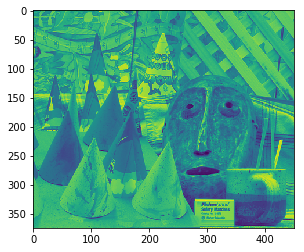

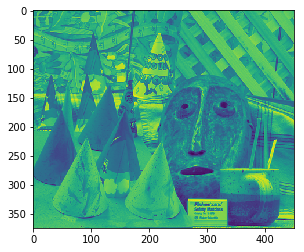

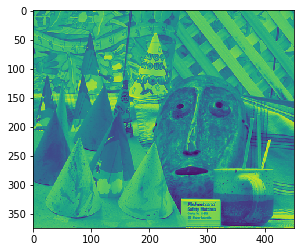

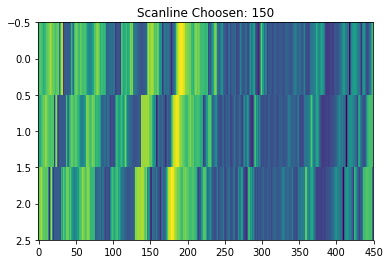

'\na = np.random.rand(3, 3)\na[0] = np.array([84, 150, 60])\na[1] = np.array([92, 13, 162])\na[2] =  np.array([21, 145, 52])\nplt.imshow(a)\n'

In [17]:
#Load image:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt


imgLeft = Image.open('./im4.ppm').convert('L')
imgMiddle = Image.open('./im5.ppm').convert('L')
imgRight = Image.open('./im6.ppm').convert('L')

a = imgLeft.size
print("original size of the figure: {}".format(a))
reshapeSize = (int(a[0] /2), int(a[1]/ 2))
print("We resize the figure in : {}".format(reshapeSize))

imgLeft = imgLeft.resize(reshapeSize, Image.ANTIALIAS)
imgMiddle = imgMiddle.resize(reshapeSize, Image.ANTIALIAS)
imgRight = imgRight.resize(reshapeSize, Image.ANTIALIAS)

numpyLeftImg = np.asarray(imgLeft)
numpyMiddleImg = np.asarray(imgMiddle)
numpyRightImg = np.asarray(imgRight)


#numpyLeftImg = numpyLeftImg[:, 300:300+450]
#numpyMiddleImg = numpyMiddleImg[:, 300:300+450]
#numpyRightImg = numpyRightImg[:, 300:300+450]



scanlineChoosen = 150


# Let's begin with a size of 100 for test

#numpyLeftImg = numpyLeftImg
#numpyMiddleImg = numpyMiddleImg
#numpyRightImg = numpyRightImg


#plt.figure()
#plt.subplot(311)
plt.imshow(numpyLeftImg)
plt.show()
#plt.subplot(312)
plt.imshow(numpyMiddleImg)
plt.show()
#plt.subplot(313)
plt.imshow(numpyRightImg)
plt.show()




a = np.full((3, numpyLeftImg.shape[1]), 0)
a[0, :] = numpyLeftImg[scanlineChoosen, :]
a[1, :] = numpyMiddleImg[scanlineChoosen, :]
a[2: ,:] = numpyRightImg[scanlineChoosen, :]
plt.title("Scanline Choosen: " + str(scanlineChoosen))
plt.imshow(a, interpolation='nearest', aspect='auto')
plt.show()



"""
a = np.random.rand(3, 9)
a[0] = np.array([130, 150, 140, 0, 0, 10, 0, 0, 0])
a[1] = np.array([0, 0, 0, 0, 120, 134, 162, 20, 7])
a[2] =  np.array([50, 50, 50, 3, 15, 41, 115, 130, 152])
plt.imshow(a)
"""


"""
a = np.random.rand(3, 4)
a[0] = np.array([84, 150, 60, 21])
a[1] = np.array([92, 13, 72, 162])
a[2] =  np.array([21, 90, 148, 20])
plt.imshow(a)
"""

#With size 3, it works !
"""
a = np.random.rand(3, 3)
a[0] = np.array([84, 150, 60])
a[1] = np.array([92, 13, 162])
a[2] =  np.array([21, 145, 52])
plt.imshow(a)
"""


In [18]:
## The main 

#lenSequence = reshapeSize[0] + 1
lenSequence = 450
lenSequence += 1


print("I BEGIN TO LOAD")
#elementChoosen_history = cp.load("./lenSeq_" + str(lenSequence) + "/elementChoosen_history.npy")
indexPositionArray = cp.load("./lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

elementChoosen_history = cp.full((3*lenSequence**3, ), -1)
elementChoosen_history[:lenSequence**3] += position_in_nw_flatten_matrix // (lenSequence+1)**2
elementChoosen_history[lenSequence**3:2*lenSequence**3] += (position_in_nw_flatten_matrix // (lenSequence+1)) % (lenSequence+1)
elementChoosen_history[2*lenSequence**3:3*lenSequence**3] += position_in_nw_flatten_matrix % (lenSequence+1)
print("FINISH TO LOAD")


seq1 = numpyLeftImg[scanlineChoosen, :]
seq2 = numpyMiddleImg[scanlineChoosen, :]
seq3 = numpyRightImg[scanlineChoosen, :]

print(seq3.shape)


"""
seq1 = cp.array([130, 150, 140, 30, 20, 10, 0, 0, 0])
seq2 =cp.array([0, 11, 19, 32, 120, 134, 162, 20, 7])
seq3 = cp.array([0, 0, 4, 3, 15, 41, 115, 130, 152])
"""

"""
seq1 = a[0]
seq2 = a[1]
seq3 = a[2]
"""



#print(seq1)
#print(seq2)
#print(seq3)

sequenceNumber1 = seq1
sequenceNumber2 = seq2
sequenceNumber3 = seq3



u1 = cp.empty((lenSequence, ), dtype=cp.int32)
u1[0] = -256*2-1
u1[1:] = cp.array(seq1)

u2 = cp.empty((lenSequence, ), dtype=cp.int32)
u2[0] = -256*3-1
u2[1:] = cp.array(seq2)

u3 = cp.empty((lenSequence, ), dtype=cp.int32)
u3[0] = -256*4-1
u3[1:] = cp.array(seq3)

#print(u1)
#print(u2)
#print(u3)

print(u1.shape)
print(u2.shape)
print(u3.shape)

print(u1)
print(u2)
print(u3)

I BEGIN TO LOAD
FINISH TO LOAD
(450,)
(451,)
(451,)
(451,)
[-513  171  166  169  177  169  163  167  155  160  156  165  177  180
  185  185  190  203  202  191  184  183  182  177  171  178  177  179
  184  108   60  164  203  208  148   63   88   88   94   92   89   91
   93   93   95   79  163  129  103  171  167  181  187  186  178  167
  166  180  182  177  168  166  169  171  172  167  156  135  129  124
  120  124  128  138  146  150  177  173  175  190  194  189  186  176
  157  165  168  166  162  158  163  156   99   93   98   98  102  105
  106  107   91   99  111  109  111   70   75   86   85   82   83   70
  119  174  167  151  143  156  159  170  166  151  154  160  182  191
  181  190  150  117  115  110  105  105  100   98   93   90   85   85
   84   83   88   87   89   93   96   93  177  201  188  200  196  201
  200  200  194  173  180  179  172  186  180  101  140  133  137  102
   63   85  115  105  106  104  106  109  110   90   86  110   54   84
  102   95  105  1

In [19]:
    start = time.time()

    print("COMPUTE SCORE MATRIX : ")
    scoreMatrix, tempsPasseAtEachStep = computeScoringMatrix(u1, u2, u3)

    end = time.time()
    print("\nTemps passe pour calculer la matrice : {} secondes".format(end - start))

COMPUTE SCORE MATRIX : 
1351 / 1351
Temps passe pour calculer la matrice : 7.27583885193 secondes


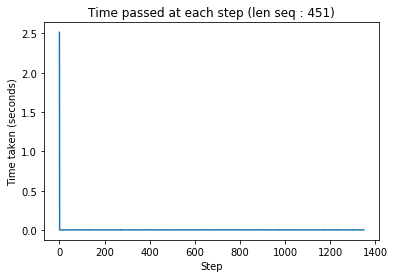

Mean : 0.005049809879726834
Var : 0.004666049336912822


In [20]:
plt.plot(list(cp.arange(len(tempsPasseAtEachStep))), tempsPasseAtEachStep)
plt.title("Time passed at each step (len seq : " + str(lenSequence) + ")")
plt.xlabel("Step")
plt.ylabel("Time taken (seconds)")
plt.show()

arrayTempsPasseAtEachStep = cp.asarray(tempsPasseAtEachStep[:])
print("Mean : {}\nVar : {}".format(arrayTempsPasseAtEachStep.mean(), arrayTempsPasseAtEachStep.var()))


DETERMINATE PASS : 
(452, 452, 452)
ALIGN SEQUENCES : 
Disparity : 
[[22 24 24 24 26 26 26 26 26 26 26 28 28 28 28 28 28 28 28 28 28 28 28 28
  28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 34 34 36 36 36 36 38 38 38
  38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
  38 38 38 34 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
  28 28 28 28 28 28 28 28 28 28 28 28 28 32 34 34 34 34 34 34 34 34 34 34
  34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
  34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 32 32 32 32 32 32
  32 32 32 32 32 32 32 32 32 32 32 30 30 28 26 28 28 28 28 28 28 28 28 28
  28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
  28 28 28 28 28 28 28 28 28 28 28 30 30 32 32 32 32 32 32 32 32 32 32 32
  32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
  32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32
  32 32 32 32 32 32 32 32 32 32 32 32 32 32 

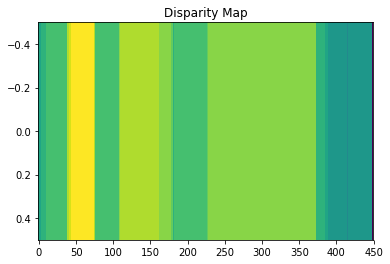

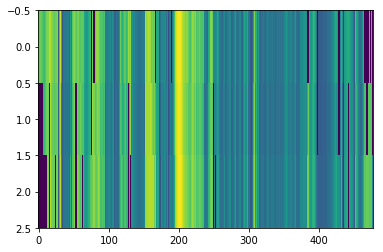

Len seq : 450


In [21]:
  #print(scoreMatrix)
  print("DETERMINATE PASS : ")
  print(scoreMatrix.shape)
  path = determinatePath(cp.asnumpy(scoreMatrix), scoreMatrix.shape)
  
  #print(path)

  print("ALIGN SEQUENCES : ")
  S1final, S2final, S3final = alignSequences(seq1, seq2, seq3, path)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  DisparityMapS3 = []
  
 # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0
    else:
      DisparityMapS1.append(i)
   # else:
   #   S1final[i] = int(S1final[i] / 2)

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
    else:
      DisparityMapS2.append(i)
    #else:
    #  S2final[i] = int(S2final[i] / 2)

  for i in range(len(S3final)):
    if (S3final[i] == '-'):
      S3final[i] = 0
    else:
      DisparityMapS3.append(i)
    #else:
    #  S3final[i] = int(S3final[i] / 2)
    
    
    
    
  #print("Disparity : ")
  #print(DisparityMapS1)
  #print(DisparityMapS2)
  #print(DisparityMapS3)
    
  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  DisparityMapS3 = np.array(DisparityMapS3)
  #distance = np.power(DisparityMapS1 - DisparityMapS2, 2) + np.power(DisparityMapS1 - DisparityMapS3, 2) + np.power(DisparityMapS2 - DisparityMapS3, 2)
  distance = np.abs(DisparityMapS1 - DisparityMapS2) + np.abs(DisparityMapS1 - DisparityMapS3) + np.abs(DisparityMapS2 - DisparityMapS3)

  print("Disparity : ")
  distance = distance.reshape((1, len(distance)))
  print(distance)
  plt.imshow(distance, interpolation='nearest', aspect='auto')
  plt.title("Disparity Map")
  plt.show()



  a = np.full((3, max(len(S1final), len(S2final), len(S3final))), 0)
  a[0, :len(S1final)] = np.array(S1final, dtype=np.int32)
  a[1, :len(S2final)] = S2final
  a[2:, :len(S3final)] = S3final
  plt.imshow(a, interpolation='nearest', aspect='auto')
  plt.show()
  print("Len seq : {}".format(len(seq1)))
  


In [22]:
numberScanLine = reshapeSize[1]
#lenSequence = reshapeSize[0] + 1
lenSequence = 450 # Enter le len of the sequence here
lenSequence += 1


print("I BEGIN TO LOAD")
#elementChoosen_history = cp.load("./lenSeq_" + str(lenSequence) + "/elementChoosen_history.npy")
indexPositionArray = cp.load("./lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

elementChoosen_history = cp.full((3*lenSequence**3, ), -1)
elementChoosen_history[:lenSequence**3] += position_in_nw_flatten_matrix // (lenSequence+1)**2
elementChoosen_history[lenSequence**3:2*lenSequence**3] += (position_in_nw_flatten_matrix // (lenSequence+1)) % (lenSequence+1)
elementChoosen_history[2*lenSequence**3:3*lenSequence**3] += position_in_nw_flatten_matrix % (lenSequence+1)
print("I FINISH TO LOAD")




disparityMap = np.empty((numberScanLine, lenSequence-1))
disparityMap2 = np.empty((numberScanLine, lenSequence-1))
disparityMap3 = np.empty((numberScanLine, lenSequence-1))
disparityMap4 = np.empty((numberScanLine, lenSequence-1))
disparityMap5 = np.empty((numberScanLine, lenSequence-1))
begin_compute = time.time()
for k in range(numberScanLine):
  print("Scanline : {} / {}".format(k, numberScanLine))
  scanlineChoosen = k
  seq1 = numpyLeftImg[scanlineChoosen, :]
  seq2 = numpyMiddleImg[scanlineChoosen, :]
  seq3 = numpyRightImg[scanlineChoosen, :]
  sequenceNumber1 = seq1
  sequenceNumber2 = seq2
  sequenceNumber3 = seq3



  u1 = cp.empty((lenSequence, ), dtype=cp.int32)
  u1[0] = -256*2-1
  u1[1:] = cp.array(seq1)

  u2 = cp.empty((lenSequence, ), dtype=cp.int32)
  u2[0] = -256*3-1
  u2[1:] = cp.array(seq2)

  u3 = cp.empty((lenSequence, ), dtype=cp.int32)
  u3[0] = -256*4-1
  u3[1:] = cp.array(seq3)
  
  scoreMatrix, tempsPasseAtEachStep = computeScoringMatrix(u1, u2, u3)

  path = determinatePath(cp.asnumpy(scoreMatrix), scoreMatrix.shape)
  S1final, S2final, S3final = alignSequences(seq1, seq2, seq3, path)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  DisparityMapS3 = []
  """
 # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0
    else:
      DisparityMapS1.append(i)
   # else:
   #   S1final[i] = int(S1final[i] / 2)

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
    else:
      DisparityMapS2.append(i)
    #else:
    #  S2final[i] = int(S2final[i] / 2)

  for i in range(len(S3final)):
    if (S3final[i] == '-'):
      S3final[i] = 0
    else:
      DisparityMapS3.append(i)
      
    
  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  DisparityMapS3 = np.array(DisparityMapS3)
  #distance = np.abs(DisparityMapS1 - DisparityMapS2) + np.abs(DisparityMapS1 - DisparityMapS3) + np.abs(DisparityMapS2 - DisparityMapS3)
  #distance2 = (np.abs(DisparityMapS1 - DisparityMapS2) + np.abs(DisparityMapS2 - DisparityMapS3)) / 2
  distance3 = np.abs(DisparityMapS1 - DisparityMapS2)
  distance4 = np.abs(DisparityMapS3 - DisparityMapS2)
  distance5 = np.abs(DisparityMapS1 - DisparityMapS3)
  distance = DisparityMapS1
  distance2 = DisparityMapS3

  distance = distance.reshape((1, len(distance)))
  disparityMap[k] = distance
  disparityMap2[k] = distance2
  disparityMap3[k] = distance3
  disparityMap4[k] = distance4
  disparityMap5[k] = distance5
  """
  shift1 = 0
  shift2 = 0
  for i in range(len(S1final)):
    if (S1final[i] != '-' and S2final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS2.append(shift2)
      shift1 += 1
      shift2 += 1
    elif (S1final[i] != '-' and S2final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)
    else:
      shift2 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)

  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS2)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap[k] = distance 
  
  DisparityMapS1 = []
  DisparityMapS3 = []
  
  shift1 = 0
  shift3 = 0
  for i in range(len(S1final)):
    if (S1final[i] != '-' and S3final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS3.append(shift3)
      shift1 += 1
      shift3 += 1
    elif (S1final[i] != '-' and S3final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS3.append(0)
    else:
      shift3 += 1
      DisparityMapS1.append(0)
      DisparityMapS3.append(0)

  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS3 = np.array(DisparityMapS3)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS3)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap2[k] = distance 

end_compute = time.time()
print("Time taken : {} secs".format(end_compute - begin_compute))

I BEGIN TO LOAD
I FINISH TO LOAD
Scanline : 0 / 375
1351 / 1351Scanline : 1 / 375
1351 / 1351Scanline : 2 / 375
1351 / 1351Scanline : 3 / 375
1351 / 1351Scanline : 4 / 375
1351 / 1351Scanline : 5 / 375
1351 / 1351Scanline : 6 / 375
1351 / 1351Scanline : 7 / 375
1351 / 1351Scanline : 8 / 375
1351 / 1351Scanline : 9 / 375
1351 / 1351Scanline : 10 / 375
1351 / 1351Scanline : 11 / 375
1351 / 1351Scanline : 12 / 375
1351 / 1351Scanline : 13 / 375
1351 / 1351Scanline : 14 / 375
1351 / 1351Scanline : 15 / 375
1351 / 1351Scanline : 16 / 375
1351 / 1351Scanline : 17 / 375
1351 / 1351Scanline : 18 / 375
1351 / 1351Scanline : 19 / 375
1351 / 1351Scanline : 20 / 375
1351 / 1351Scanline : 21 / 375
1351 / 1351Scanline : 22 / 375
1351 / 1351Scanline : 23 / 375
1351 / 1351Scanline : 24 / 375
1351 / 1351Scanline : 25 / 375
1351 / 1351Scanline : 26 / 375
1351 / 1351Scanline : 27 / 375
1351 / 1351Scanline : 28 / 375
1351 / 1351Scanline : 29 / 375
1351 / 1351Scanline : 30 / 375
1351 / 1351Scanline : 31 / 

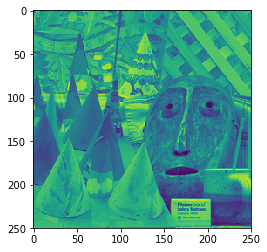

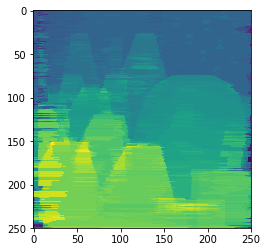

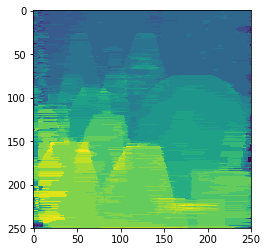

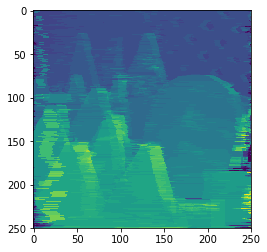

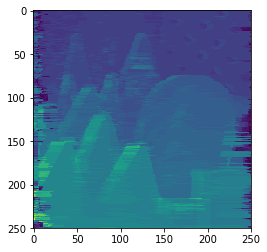

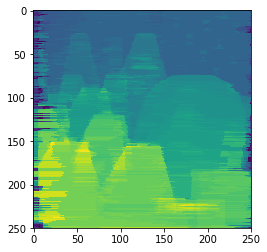

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()
plt.imshow(disparityMap3)
plt.show()
plt.imshow(disparityMap4)
plt.show()
plt.imshow(disparityMap5)
plt.show()

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

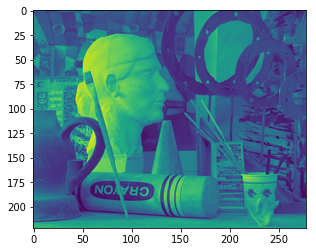

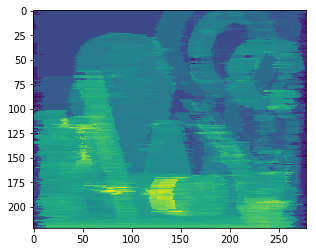

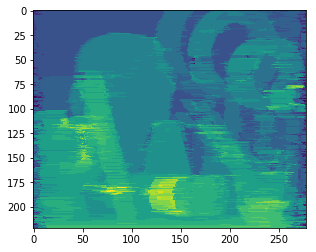

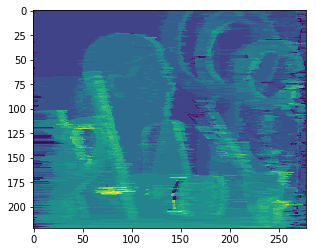

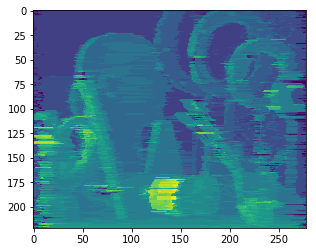

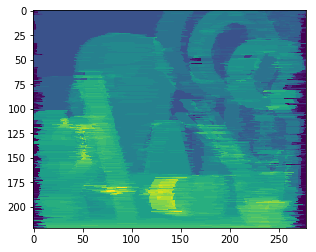

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()
plt.imshow(disparityMap3)
plt.show()
plt.imshow(disparityMap4)
plt.show()
plt.imshow(disparityMap5)
plt.show()
 

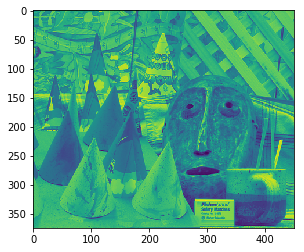

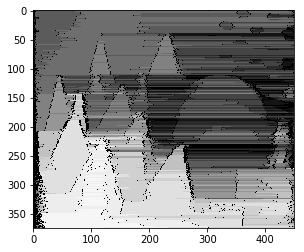

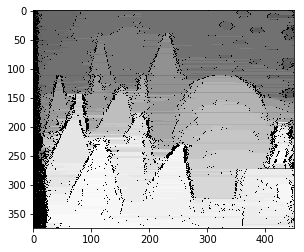

In [0]:
print("GAP SCORE: {}".format(GAP_SCORE)) 
print("MATCH_SCORE_TWO_SEQ: {}".format(MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()

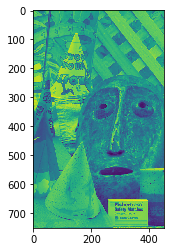

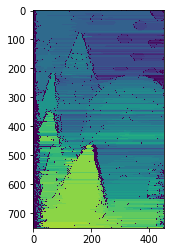

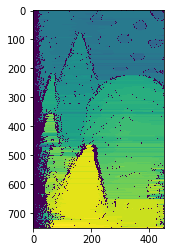

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()

GAP SCORE: -8
MATCH_SCORE_TWO_SEQ: 70


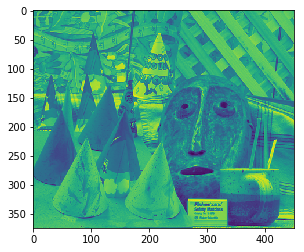

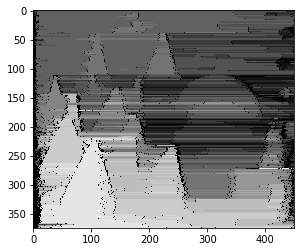

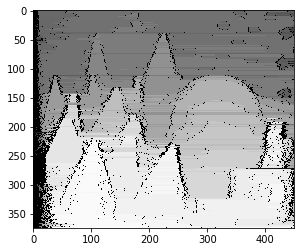

In [23]:
print("GAP SCORE: {}".format(GAP_SCORE)) 
print("MATCH_SCORE_TWO_SEQ: {}".format(MATCH_SCORE_TWO_SEQ))

plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()


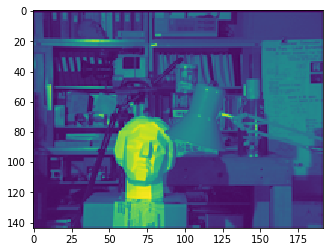

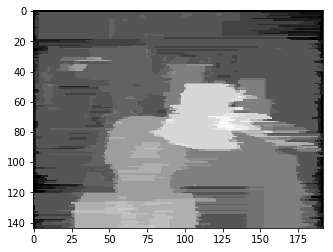

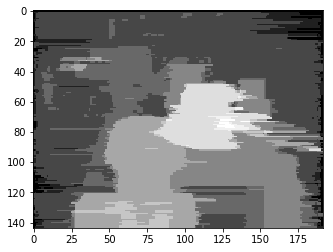

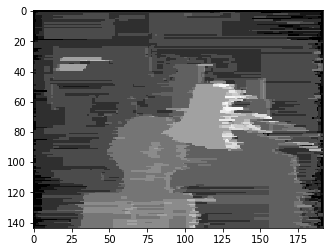

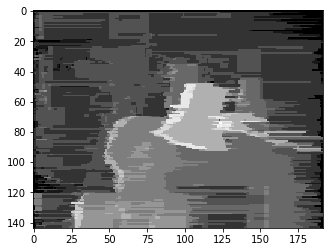

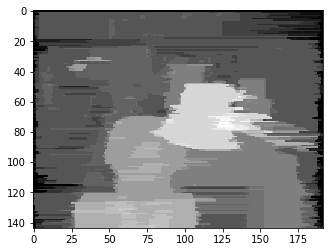

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

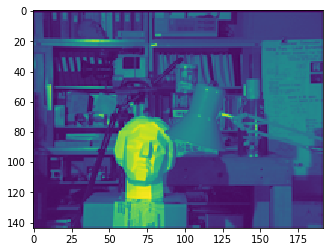

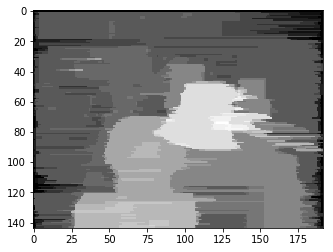

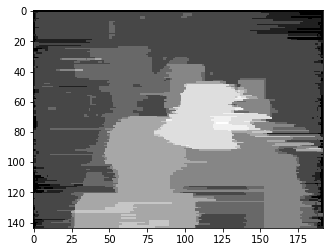

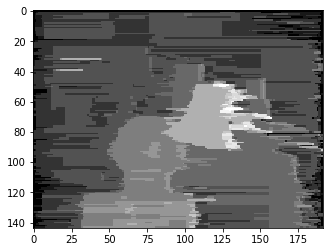

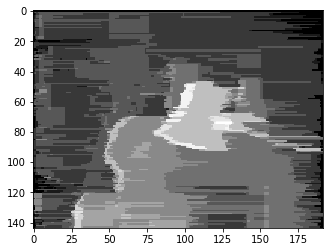

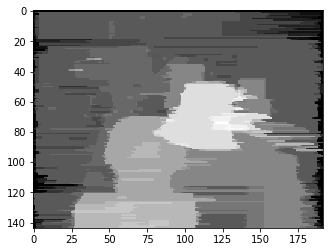

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

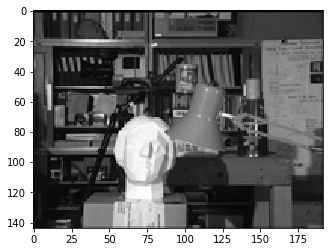

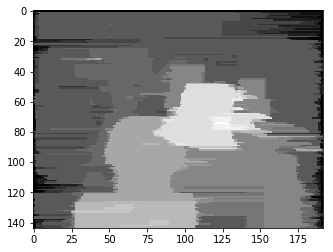

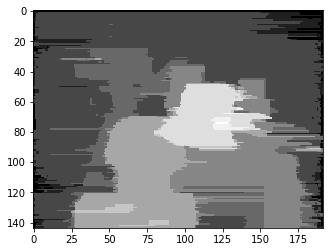

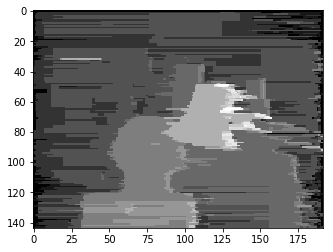

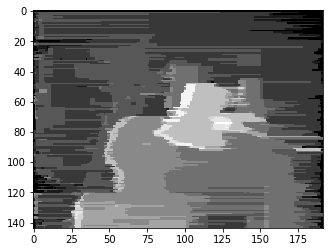

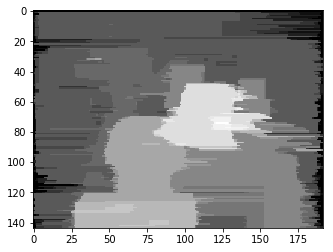

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

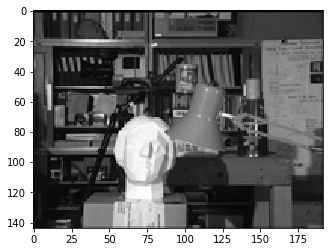

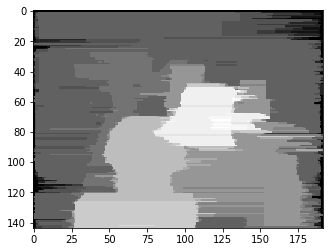

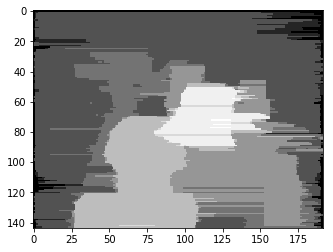

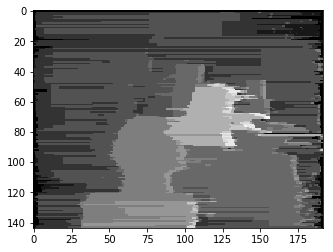

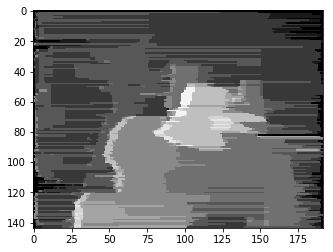

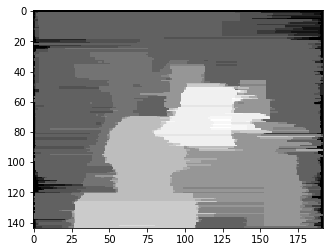

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

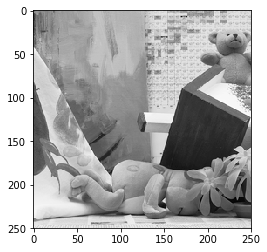

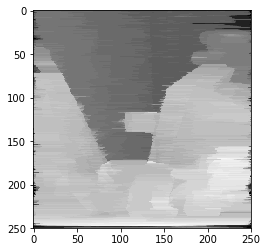

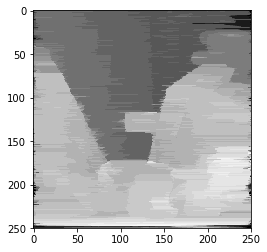

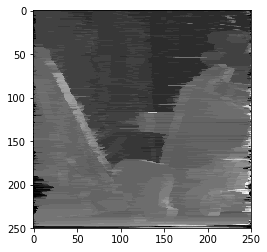

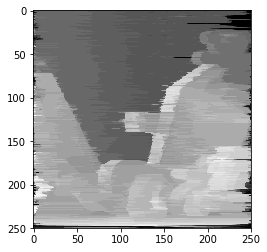

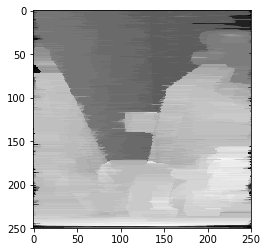

In [0]:
plt.imshow(numpyMiddleImg, cmap=matplotlib.cm.Greys_r)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap2, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap3, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap4, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap5, cmap=matplotlib.cm.Greys_r)
plt.show()

In [0]:
plt.imsave("disparityMap_art_1", disparityMap3)
plt.imsave("disparityMap_art_2", disparityMap4)

In [0]:
!nvidia-smi

Wed Jul 24 10:33:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    70W / 149W |   3677MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

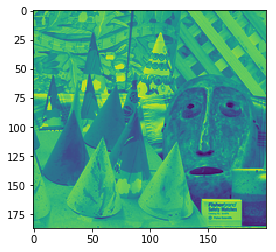

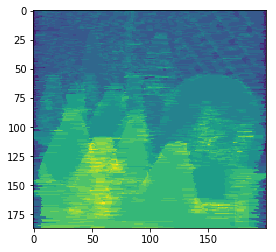

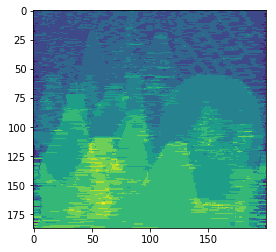

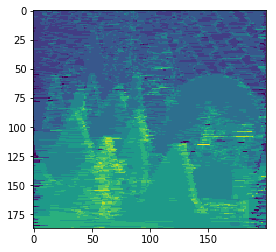

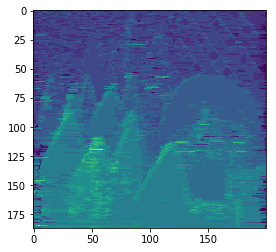

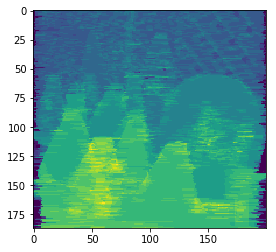

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap)
plt.show()
plt.imshow(disparityMap2)
plt.show()
plt.imshow(disparityMap3)
plt.show()
plt.imshow(disparityMap4)
plt.show()
plt.imshow(disparityMap5)
plt.show()

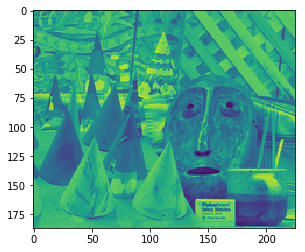

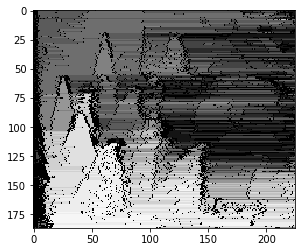

In [0]:
plt.imshow(numpyMiddleImg)
plt.show()
#plt.imshow(disparityMap, interpolation='nearest', aspect='auto')
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()